# Tutorial 3: Adaptive Measurements

In this tutorial, we explore the adaptive functionality of the MeasurementControl. With this mode, instead of predefining a grid of values to sweep through, we provide an optimization function and an initial state to the MC. The MC will then use this function to build the sweep. We import our usual modules and setup an MC with visualization: 

In [1]:
from quantify.measurement.control import MeasurementControl
import quantify.visualization.pyqt_plotmon as pqm

/home/cattryde/PycharmProjects/quantify/venv/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
MC = MeasurementControl('MC')
plotmon = pqm.PlotMonitor_pyqt('plotmon_MC')
MC.instr_plotmon(plotmon.name)

## Finding a minima
We will create a mock Instrument our MC will interact with. In this case, it is a simple parabola centred at the origin.

In [3]:
from qcodes.instrument.base import Instrument
from qcodes import ManualParameter
from qcodes.utils import validators as vals
import time
import numpy as np

class DummyParHolder(Instrument):
    def __init__(self, name):
        super().__init__(name)

        for parname in ["x", "y", "z", "x0", "y0", "z0"]:
            self.add_parameter(
                parname,
                unit="m",
                parameter_class=ManualParameter,
                vals=vals.Numbers(),
                initial_value=0.,
            )

        self.add_parameter(
            "noise",
            unit="V",
            label="white noise amplitude",
            parameter_class=ManualParameter,
            vals=vals.Numbers(),
            initial_value=0,
        )

        self.add_parameter(
            "delay",
            unit="s",
            label="Sampling delay",
            parameter_class=ManualParameter,
            vals=vals.Numbers(),
            initial_value=0,
        )

        self.add_parameter("parabola", unit="V", get_cmd=self._measure_parabola)

    def _measure_parabola(self):
        time.sleep(self.delay())
        return (
            (self.x() - self.x0()) ** 2
            + (self.y() - self.y0()) ** 2
            + (self.z() - self.z0()) ** 2
            + self.noise() * np.random.rand(1)
        )


In [4]:
dummy_parabola = DummyParHolder('parabola')

Next, we will use the `optimize` package from `scipy` to provide our adaptive function. You can of course implement your own functions for this purpose, but for brevity we will use something standard and easily available.

In [5]:
from scipy import optimize

Then, we set our Settables and Gettables and usual, and define a new dictionary `af_pars`. The only required key in this object is "adaptive_function", the value of which being the adaptive function to use. The remaining fields in this dictionary are the arguments to the adaptive function itself. We also add some noise into the parabola to stress our adaptive function.

We will use the `optimize.minimize` function, which requires an initial state named "x0" and an algorithm to use named "method". In this case, we are starting at (-50, -50) and hope to minimize these values relative to our parabola function. Of course, this parabola has it's global minimum at the origin, thus these values will tend towards 0 as our algorithm progresses.

Note - The progress meter is unreliable in this mode due to the halting problem

In [6]:
MC.settables([dummy_parabola.x, dummy_parabola.y])
af_pars = {
    "adaptive_function": optimize.minimize,
    "x0": [-50, -50],
    "method": "Nelder-Mead"
}
dummy_parabola.noise(0.5)
MC.gettables(dummy_parabola.parabola)
dset = MC.run_adaptive('nelder_mead', af_pars)

 100% completed 	elapsed time: 4.1s 	time left: 0.0s


In [7]:
dset

<xarray.Dataset>
Dimensions:  (dim_0: 512)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 -50.0 -52.5 -50.0 -47.5 ... 0.05115 0.05115 0.05115
    x1       (dim_0) float64 -50.0 -50.0 -52.5 -52.5 ... 0.161 0.161 0.161 0.161
    y0       (dim_0) float64 5e+03 5.257e+03 5.256e+03 ... 0.4056 0.4239 0.295
Attributes:
    tuid:     20200804-165907-971-7626d7
    name:     nelder_mead
    2D-grid:  False

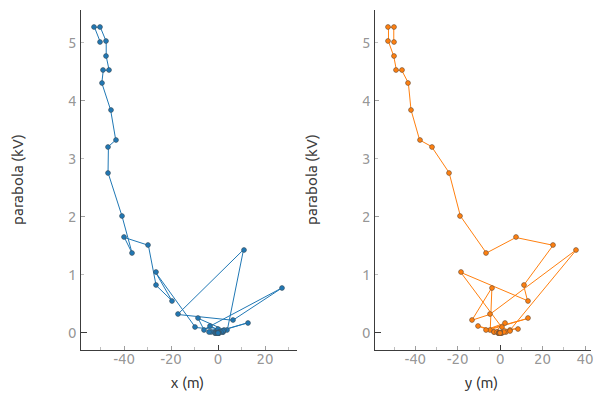

In [8]:
plotmon.main_QtPlot

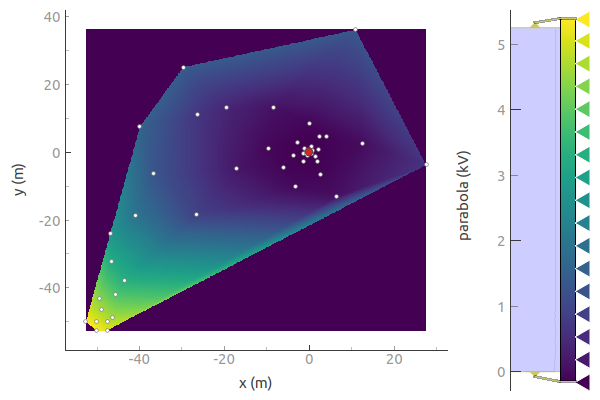

In [9]:
plotmon.secondary_QtPlot

We can see from the graphs that our xn values in the dataset snake towards 0 as expected. Success!

## A different approach
Quantify is designed to be modular and the adaptive functions support is no different. To this end, the MC has first class support for the `adaptive` package. Let's see what the same experiment looks like with this module. Note the fields of the `af_pars` dictionary have changed to be compatible with the different adaptive function we are using.


NOTE, I'm not really sure what the below goal is indicating, this is lifted from pycqed

In [10]:
import adaptive

dummy_parabola.noise(0)
MC.settables([dummy_parabola.x, dummy_parabola.y])
af_pars = {
    "adaptive_function": adaptive.learner.Learner2D,
    "goal": lambda l: l.npoints > 20 * 20,
    "bounds": ((-50, 50), (-20, 30)),
}
MC.gettables(dummy_parabola.parabola)
dset = MC.run_adaptive('adaptive sample', af_pars)

 100% completed 	elapsed time: 4.5s 	time left: 0.0s
 475% completed 	elapsed time: 5.0s 	time left: -4.0s

In [11]:
dset

<xarray.Dataset>
Dimensions:  (dim_0: 512)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 -50.0 -50.0 50.0 50.0 ... -4.87 34.27 -20.01 -45.04
    x1       (dim_0) float64 -20.0 30.0 -20.0 30.0 ... 14.96 3.388 -14.8 -10.43
    y0       (dim_0) float64 2.9e+03 3.4e+03 2.9e+03 ... 619.7 2.137e+03
Attributes:
    tuid:     20200804-165913-543-1857d0
    name:     adaptive sample
    2D-grid:  False

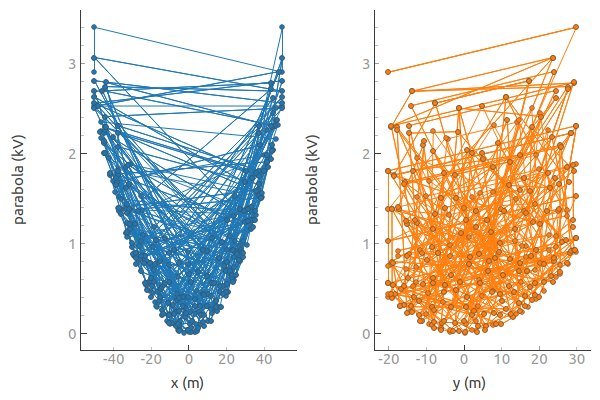

In [12]:
plotmon.main_QtPlot

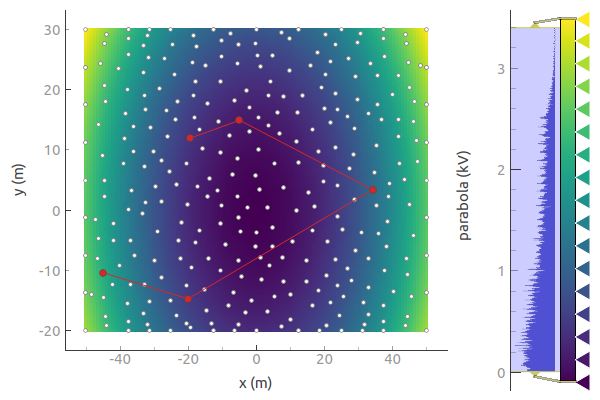

In [13]:
plotmon.secondary_QtPlot